## Nagel-Schrankenberg Cellular Automata Simulation

In [1]:
import numpy as np 

class TrafficSimulation:
    def __init__(self, length = 100, density = 0.5, maxv = 5, pslow = 0.5):
        """
        length = length of road (it wraps around)
        density = length/cars
        maxv = max velocity any (and all) cars can go.
        pslow = probability of slowing down (default 0.5)
        """

        self.length = length
        self.density = density
        self.maxv = maxv
        self.pslow = pslow
    
        self.state = [maxv if i <= length*density else -1 for i in range(length)]
        np.random.shuffle(self.state)
        
    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.state))
        
    def calculate(self):
        for i, v in enumerate(self.state):
            if v >= 0:
                d = 1
                # find distance to next car, d
                while self.state[(i + d) % self.length] == -1: d += 1
                
                # adjust speed - if distance to next car > speed, +1 velocity. 
                # If less, slow down to d-1
                self.state[i] = min(self.state[i] + 1, self.maxv) if d > v + 1 else (d-1)
                
                # decrease speed by 1 with probability pslow
                if (self.state[i] > 0 and np.random.random() < self.pslow): self.state[i] -= 1
                   
                    
    def update(self):
        newstate = [-1] * self.length

        for i, v in enumerate(self.state):
            if v >= 0: 
                newstate[(i + v) % self.length] = v
        
        self.state = newstate
        
    def run(self, n, verbose = False):
        for i in range(n):
            self.calculate()
            if verbose: self.display()
            self.update()
            

In [2]:
np.random.seed(seed = 20)
# traffic = TrafficSimulation(length = 100, density = 0.03, maxv = 5, pslow = 0.5)
traffic = TrafficSimulation(length = 80, density = 0.03, maxv = 5, pslow = 0.5)
traffic.run(20, verbose = True)

......5........5..............5.................................................
...........5........4..............5............................................
................5.......4...............5.......................................
.....................5......5................4..................................
..........................4......4...............5..............................
..............................4......5................5.........................
..................................5.......5................4....................
.......................................5.......5...............5................
............................................4.......5...............4...........
................................................5........4..............4.......
.....................................................4.......4..............5...
.4.......................................................4.......4..............
.....5......................

In [3]:
np.random.seed(seed = 69)
# traffic = TrafficSimulation(length = 100, density = 0.1, maxv = 5, pslow = 0.5)
traffic = TrafficSimulation(length = 80, density = 0.1, maxv = 5, pslow = 0.5)
traffic.run(20, verbose = True)

........5.....0.0.5.............5.............04...............2..4.............
.............01.0......5.............5........0....5.............2....5.........
.............0.01...........4.............2...1.........5..........2.......4....
.............1.0.2..............4...........2..2.............4.......2.........4
...4..........00...2................4.........1..3...............5.....3........
.......4......01.....2..................5......2....4.................3...4.....
...........2..1.1......3.....................2...3......5................3....5.
...5.........0.1.2........3....................3....4........5..............4...
4.......3....1..1..2.........4....................3.....4.........4.............
....5......1..2..1...2...........5...................3......5.........5.........
.........2..1...1.1....2..............4.................3........5.........4....
...........1.2...0.2.....3................4................4..........5........5
....5.......1..0.0...2......

## Implementing "Flow"

In [4]:
class FlowSimulation(TrafficSimulation):
    def update(self):
        newstate = [-1] * self.length
        
        flow = 0

        for i, v in enumerate(self.state):
            if v >= 0: 
                newstate[(i + v) % self.length] = v
            if i + v > self.length:
                flow += 1
        
        self.state = newstate
        
        return flow
        
    def run(self, n, verbose = False):
        flows = []
        for i in range(n):
            self.calculate()
            if verbose: self.display()
            flows.append(self.update())
        return np.mean(flows)
    

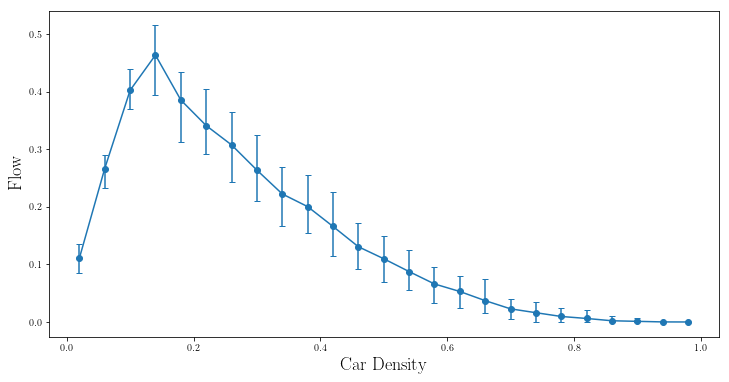

In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import latexipy as lp
import time

%matplotlib inline

mpl.rcParams['text.usetex'] = True
plt.rc('font', family='serif')


densities = np.arange(0.02, 1, 0.04).repeat(100)
flow = [FlowSimulation(100, d, 5, .2).run(n=200) for d in densities]

plt.figure(figsize=(12,6))
plt.rc('text', usetex=True)

# plt.plot(densities, flow, 'o')
plt.errorbar(np.arange(0.02, 1, 0.04),  np.mean(np.reshape(flow, (-1,100)), axis = 1),
             yerr = np.abs(np.mean(np.reshape(flow, (-1,100)), axis = 1) - 
                           np.percentile(np.reshape(flow, (-1,100)), [2.5,97.5], axis = 1)),
            fmt = '-o', capsize = 3)
# plt.plot(np.arange(0.02, 1, 0.04), np.mean(np.reshape(flow, (-1,100)), axis = 1), '-o')

# plt.title(r'\textbf{Average Vehicle Flow per Car Density}', fontsize=22)
plt.xlabel(r'Car Density', fontsize = 18)
plt.ylabel(r'Flow', fontsize = 18)

plt.savefig("Traffic Simulation/vehicleflow.png", bbox_inches='tight')
plt.show()

## Always in the Middle Rule

In [52]:
class MiddleRuleSimulation(FlowSimulation):
    def calculate(self):
        
        for i, v in enumerate(self.state):
            if v >= 0:
                d_front, d_back = 1,1

                # find distance to the front and to the back
                while self.state[(i + d_front) % self.length] == -1: d_front += 1
                while self.state[(i - d_back) % self.length] == -1: d_back += 1

                # if distance to front greater than to back, accelerate 1. If less, decelerate one.
                self.state[i] = min(v + 1, self.maxv, d_front - 1) if (d_front + 2 >= d_back) else min(max(v - 1, 0), d_front - 1)

                # decrease speed by 1 with probability pslow
                if (self.state[i] > 0 and np.random.random() < self.pslow): self.state[i] -= 1

In [53]:
middle = MiddleRuleSimulation(length = 60, density = 0.1, maxv = 5, pslow = 0.2)
middle.run(50, verbose = False)

0.26

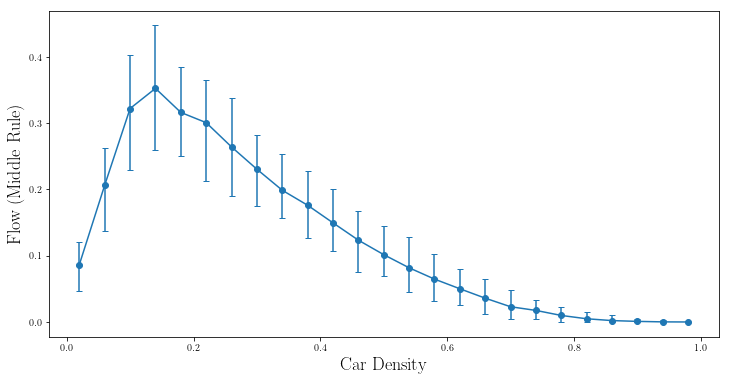

In [56]:
middleflow = [MiddleRuleSimulation(100, d, 5, .2).run(n=200) for d in densities]


plt.figure(figsize=(12,6))
plt.rc('text', usetex=True)

# plt.plot(densities, middleflow, 'o')
# plt.plot(np.arange(0.02, 1, 0.04), np.mean(np.reshape(middleflow, (-1,100)), axis = 1), '-o')

plt.errorbar(np.arange(0.02, 1, 0.04),  np.mean(np.reshape(middleflow, (-1,100)), axis = 1),
             yerr = np.abs(np.mean(np.reshape(middleflow, (-1,100)), axis = 1) - 
                           np.percentile(np.reshape(middleflow, (-1,100)), [2.5,97.5], axis = 1)),
            fmt = '-o', capsize = 3)
# plt.title(r'\textbf{Average Vehicle Flow per Car Density}', fontsize=22)
plt.xlabel(r'Car Density', fontsize = 18)
plt.ylabel(r'Flow (Middle Rule)', fontsize = 18)

plt.savefig("Traffic Simulation/middleflow.png", bbox_inches='tight')
plt.show()

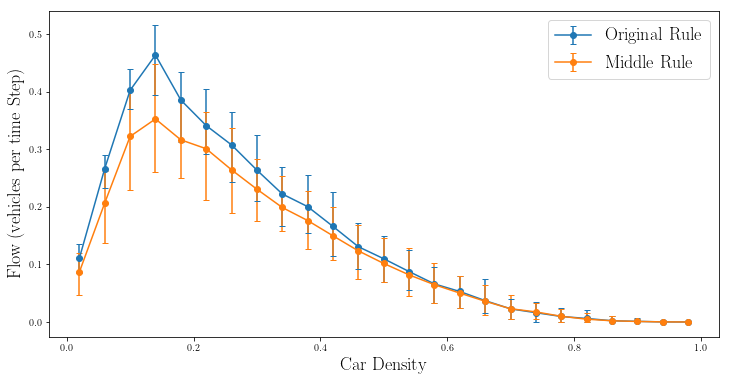

In [58]:
plt.figure(figsize=(12,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


plt.errorbar(np.arange(0.02, 1, 0.04),  np.mean(np.reshape(flow, (-1,100)), axis = 1),
             yerr = np.abs(np.mean(np.reshape(flow, (-1,100)), axis = 1) - 
                           np.percentile(np.reshape(flow, (-1,100)), [2.5,97.5], axis = 1)),
             fmt = '-o', capsize = 3, label = 'Original Rule')
plt.errorbar(np.arange(0.02, 1, 0.04),  np.mean(np.reshape(middleflow, (-1,100)), axis = 1),
             yerr = np.abs(np.mean(np.reshape(middleflow, (-1,100)), axis = 1) - 
                           np.percentile(np.reshape(middleflow, (-1,100)), [2.5,97.5], axis = 1)),
             fmt = '-o', capsize = 3, label = 'Middle Rule')

# plt.plot(densities, flow, 'o', color = 'deepskyblue', label = 'Original Rule')
# plt.plot(np.arange(0.02, 1, 0.04), np.mean(np.reshape(flow, (-1,100)), axis = 1), '-o', color = 'deepskyblue')

# plt.plot(densities, middleflow, 'o', color = 'orange', label = 'Middle Rule')
# plt.plot(np.arange(0.02, 1, 0.04), np.mean(np.reshape(middleflow, (-1,100)), axis = 1), '-o', color = 'orange')

plt.legend(prop=dict(size=18))
plt.xlabel(r'Car Density', fontsize = 18)
plt.ylabel(r'Flow (vehicles per time Step)', fontsize = 18)

plt.savefig("Traffic Simulation/middleorig.png", bbox_inches='tight')
plt.show()